<a href="https://colab.research.google.com/github/elias9080dm/XenoTox_Colab/blob/main/QSAR_Classification_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Observaciones***

Nueva versión con modificaciones:\
**Funcional completamente para modelos individuales y stacking**

Nota: Shap no se aplica para stacking (es muy tardado)







# **QSAR Clasificación Binaria**

Inspirado en el artículo de Kotli et al. (2025), este cuaderno permite construir modelos QSAR binarios sobre datos desbalanceados.

**Incluye:**
- Modelos Random Forest, XGBoost, SVM, KNN
- Balanceo de clases (SMOTE)
- Métrica principal: MCC
- Interpretabilidad con SHAP
- Y-scrambling
- Curva de cobertura
- Dominio de aplicabilidad (Leverage)
- Guardado automático de modelos, gráficas y métricas

## **1. Imports**

In [ ]:
# Instalación de librerías necesarias
%pip install pandas numpy scikit-learn scikit-optimize xgboost rdkit shap optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 16.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import sys
from pathlib import Path

# Montar Google Drive
drive.mount('/content/drive')

# Definir directorio base del proyecto
BASE_DIR = Path("/content/drive/MyDrive/QSAR/xenotox")

# Agregar proyecto al path para importar módulos propios
if BASE_DIR.exists():
    sys.path.append(str(BASE_DIR))

# Crear estructura de carpetas para outputs
(BASE_DIR / "outputs" / "models").mkdir(parents=True, exist_ok=True)
(BASE_DIR / "outputs" / "plots").mkdir(parents=True, exist_ok=True)
(BASE_DIR / "outputs" / "reports").mkdir(parents=True, exist_ok=True)


Mounted at /content/drive


In [ ]:
# General
import joblib, io
from joblib import Parallel, delayed
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
import warnings, contextlib, base64
from psutil import cpu_count
from IPython.display import HTML

# Curación y rdkit
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors, AllChem, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize

# Machine Learning
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Balanceo y pipeline general
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from qsar.utils import clean_numeric
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer

# Hiperoptimización
import optuna
from skopt.space import Real as SkReal, Integer as SkInteger, Categorical
from sklearn.base import clone, BaseEstimator, TransformerMixin
from collections import Counter

# Métricas y análisis SHAP
from sklearn.metrics import (
    make_scorer, accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, matthews_corrcoef, confusion_matrix
    )
import shap

## **2. Configuración**

In [ ]:
target_name = 'pxr' # 'ahr', 'pxr', 'car' Los nombres de los archivos deben ser {target_name}_ligands.csv
model_name = 'rf'  # 'rf', 'xgb', 'svm', 'knn'
use_stacking = True
use_hyperopt = True  # Método optuna
n_jobs = -1  # Utilizar todos los CPU disponibles
random_state = 42

## **3. Curación de base de datos**

In [ ]:
# Apagar logs de RDKit
RDLogger.DisableLog('rdApp.*')

# Función de curación
def curate_csv_data(csv_path, smiles_col="SMILES", activity_col="Activity"):
    df_raw = pd.read_csv(csv_path)
    initial_count = len(df_raw)

    # 1. Eliminar NaNs
    df = df_raw.dropna(subset=[smiles_col, activity_col]).copy()

    # 2. Convertir a molécula RDKit
    df["mol"] = df[smiles_col].apply(Chem.MolFromSmiles)
    df = df[df["mol"].notnull()].copy()

    # 3. Estandarización
    lfc = rdMolStandardize.LargestFragmentChooser()
    normalizer = rdMolStandardize.Normalizer()
    reionizer = rdMolStandardize.Reionizer()
    uncharger = rdMolStandardize.Uncharger()

    def standardize(mol):
        try:
            mol = lfc.choose(mol)
            mol = normalizer.normalize(mol)
            mol = reionizer.reionize(mol)
            mol = uncharger.uncharge(mol)
            return mol
        except Exception:
            return None

    df["mol_std"] = df["mol"].apply(standardize)
    df = df[df["mol_std"].notnull()].copy()

    # 4. Generar SMILES canónico estandarizado
    df["SMILES_std"] = df["mol_std"].apply(Chem.MolToSmiles) # Por defecto: canonical=True

    # 5. Eliminar duplicados
    df = df.drop_duplicates(subset="SMILES_std").copy()

    # 6. Resetear índices y renombrar columnas estándar
    df = df[[activity_col, "SMILES_std"]].rename(columns={"SMILES_std": "SMILES"})
    df = df.reset_index(drop=True)

    final_count = len(df)
    print(f"Curación completa: {final_count} moléculas válidas (de {initial_count} iniciales).")
    return df

# Usar la función de curación en el archivo CSV correspondiente
raw_path = f"{BASE_DIR}/ligands/{target_name}_ligands.csv"
curated_path = f"{BASE_DIR}/outputs/reports/{target_name}_ligands_curated.csv"

df_curated = curate_csv_data(raw_path)
df_curated.to_csv(curated_path, index=False)

display(df_curated.head())

Curación completa: 7651 moléculas válidas (de 7652 iniciales).


,Activity,SMILES
0,Inactive,COC(=O)c1cc(Cl)ccc1NS(=O)(=O)C(F)(F)F
1,Inactive,CCCCCCCCC(=O)NCc1ccc(O)c(OC)c1
2,Inactive,O=C1c2ccccc2C(=O)C1c1ccc2cc(S(=O)(=O)O)cc(S(=O...
3,Inactive,N#[N+]c1ccc2c(S(=O)(=O)[O-])cccc2c1O
4,Inactive,O=C(O)CCSSCCC(=O)O


## **4. Cálculo de descriptores**

In [ ]:
# 1. Función de cálculo
def calcular_descriptores(smiles):
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        return [np.nan] * len(Descriptors._descList)

    results = []

    for _, func in Descriptors._descList:
        try:
            d = func(mol)
            if d is None or isinstance(d, complex):
                d = np.nan
        except Exception:
            d = np.nan

        results.append(d)

    return results

# 2. Configuración de hilos (Ajustado al número real de CPUs disponibles)
n_cores = cpu_count()

print(f"Iniciando cálculo en paralelo con {n_cores} núcleos...")

# 3. Ejecución paralela
smiles_list = df_curated['SMILES'].tolist()
resultados = Parallel(n_jobs=n_cores)(delayed(calcular_descriptores)(s) for s in tqdm(smiles_list, desc="Progreso RDKit"))

# 4. Post-procesamiento y Alineación
# Creamos un Series temporal para usar la lógica de dropna() y mantener índices
desc_series = pd.Series(resultados, index=df_curated.index)
desc_clean = desc_series.dropna()

# 5. Crear X como DataFrame
feature_names = [name for name, _ in Descriptors._descList]
X = pd.DataFrame(desc_clean.tolist(), index=desc_clean.index, columns=feature_names)

# 6. Etiquetas y DataFrame original alineados
y = df_curated.loc[desc_clean.index, "Activity"].values
df_curated = df_curated.loc[desc_clean.index].reset_index(drop=True)

# 7. Reporte final
print(f"\nProceso completado.")
print(f"Dataset: {target_name} | Moléculas finales: {len(X)} | Descriptores: {X.shape[1]}")

# Guardar CSV curado
out_path = f"{BASE_DIR}/outputs/reports/{target_name}_ligands_descriptors.csv"
df_curated.to_csv(out_path, index=False)
print(f"Archivo guardado en: {out_path}")

Iniciando cálculo en paralelo con 2 núcleos...


Progreso RDKit: 100%|██████████| 7651/7651 [01:29<00:00, 85.36it/s] 



Proceso completado.
Dataset: pxr | Moléculas finales: 7651 | Descriptores: 217
Archivo guardado en: /content/drive/MyDrive/QSAR/xenotox/outputs/reports/pxr_ligands_descriptors.csv


### 4.1 Visualizar distribución de clases

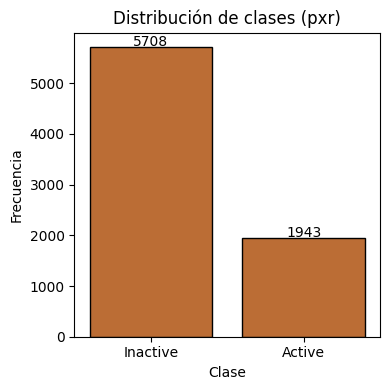

Histograma guardado en: /content/drive/MyDrive/QSAR/xenotox/outputs/plots/pxr_class_distribution.png


In [ ]:
# Histograma de clases en la base de datos curada
activity_col = "Activity"
plt.figure(figsize=(4, 4))
ax = sns.countplot(x=activity_col, data=df_curated, edgecolor='black', color='chocolate')
plt.title(f"Distribución de clases ({target_name})")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom',
        xytext=(0, -1),
        textcoords='offset points'
    )

plt.tight_layout()

# Guardar figura
out_path = f"{BASE_DIR}/outputs/plots/{target_name}_class_distribution.png"
plt.savefig(out_path, dpi=300)
plt.show()

print(f"Histograma guardado en: {out_path}")


## **5. División estratificada**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.25,
    random_state=random_state
)

print(f"Train: {len(X_train)} | Test: {len(X_test)}")


Train: 5738 | Test: 1913


In [ ]:
def build_preprocessor():
    return Pipeline([
        ("clean", FunctionTransformer(clean_numeric, validate=False)),
        ("imputer", SimpleImputer(strategy="median")),
        ("variance", VarianceThreshold(threshold=0.01)),
        ("scaler", StandardScaler())
    ])

## **7. Hiperoptimización Optuna**

In [ ]:
# === Función segura de StratifiedKFold ===
def safe_stratified_kfold(y, max_folds=5, shuffle=True, random_state=42):
    counts = Counter(y)
    min_class_count = min(counts.values())
    n_splits = min(max_folds, min_class_count)
    if n_splits < 2:
        raise ValueError(f"No se puede usar validación cruzada: solo hay {min_class_count} muestras en la clase menor.")
    return StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)


# === MAIN OPTIMIZATION FUNCTION ===
def optimize_model(X_train_proc, y_encoded, model_name, n_jobs=1, random_state=42):
    """
    Optimiza un modelo base usando Optuna.
    El preprocesamiento de X debe realizarse externamente mediante un pipeline entrenado SOLO en train.
    """

    # ==================================================
    # 1. Cálculo de smote_k
    # ==================================================
    min_class = min(Counter(y_encoded).values())
    smote_k = max(1, min(min_class - 1, 5))

    # ==================================================
    # 2. Selección del modelo base (SIN preprocessing)
    # ==================================================
    if model_name == "xgb":
        base_model = XGBClassifier(
            eval_metric="logloss",
            random_state=random_state,
            n_jobs=n_jobs,
            tree_method="hist"
        )

    elif model_name == "rf":
        base_model = RandomForestClassifier(
            n_jobs=n_jobs,
            random_state=random_state
        )

    elif model_name == "svm":
        base_model = SVC(
            probability=True,
            random_state=random_state,
            kernel="rbf"
        )

    elif model_name == "knn":
        base_model = KNeighborsClassifier(
            n_jobs=n_jobs
        )

    else:
        raise ValueError(f"Modelo no soportado: {model_name}")

    # ==================================================
    # 3. Validación cruzada segura
    # ==================================================
    cv = safe_stratified_kfold(
        y_encoded,
        max_folds=5,
        random_state=random_state
    )

    mcc_scorer = make_scorer(matthews_corrcoef)

    # ==================================================
    # 4. Función objetivo para Optuna
    # ==================================================
    def objective(trial):

        if model_name == "xgb":
            params = {
                "model__n_estimators": trial.suggest_int("model__n_estimators", 300, 800),
                "model__max_depth": trial.suggest_int("model__max_depth", 3, 7),
                "model__learning_rate": trial.suggest_float("model__learning_rate", 0.01, 0.2, log=True),
                "model__subsample": trial.suggest_float("model__subsample", 0.6, 0.9),
                "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 0.9),
                "model__gamma": trial.suggest_float("model__gamma", 0, 0.3),
                "model__min_child_weight": trial.suggest_int("model__min_child_weight", 1, 10),
                "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-5, 1, log=True),
                "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-3, 10, log=True),
            }

        elif model_name == "rf":
            params = {
                "model__n_estimators": trial.suggest_int("model__n_estimators", 300, 800),
                "model__max_depth": trial.suggest_int("model__max_depth", 8, 20),
                "model__min_samples_leaf": trial.suggest_int("model__min_samples_leaf", 1, 5),
                "model__min_samples_split": trial.suggest_int("model__min_samples_split", 2, 10),
                "model__max_features": trial.suggest_categorical(
                    "model__max_features", ["sqrt", "log2"]
                ),
            }

        elif model_name == "svm":
            params = {
                "model__C": trial.suggest_float("model__C", 0.01, 100, log=True),
                "model__gamma": trial.suggest_float("model__gamma", 1e-5, 1, log=True),
            }

        elif model_name == "knn":
            params = {
                "model__n_neighbors": trial.suggest_int("model__n_neighbors", 3, 35),
                "model__weights": trial.suggest_categorical(
                    "model__weights", ["distance", "uniform"]
                ),
                "model__p": trial.suggest_int("model__p", 1, 2),
            }

        # Pipeline SOLO con SMOTE + modelo
        trial_pipe = Pipeline([
            ("smote", SMOTE(k_neighbors=smote_k, random_state=random_state)),
            ("model", clone(base_model))
        ])

        trial_pipe.set_params(**params)

        scores = cross_val_score(
            trial_pipe,
            X_train_proc,
            y_encoded,
            scoring=mcc_scorer,
            cv=cv,
            n_jobs=1
        )

        return scores.mean()

    # ==================================================
    # 5. Optimización con Optuna
    # ==================================================
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=random_state),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )

    study.optimize(objective, n_trials=25)

    # ==================================================
    # 6. Entrenamiento final del mejor modelo
    # ==================================================
    final_pipe = Pipeline([
        ("smote", SMOTE(k_neighbors=smote_k, random_state=random_state)),
        ("model", clone(base_model))
    ])

    final_pipe.set_params(**study.best_params)
    final_pipe.fit(X_train_proc, y_encoded)

    # Guardar info útil
    final_pipe.best_params_ = study.best_params
    final_pipe.best_score_ = study.best_value

    return final_pipe

In [ ]:
def train_stacking_model(
    X_train_proc,
    y_train_enc,
    n_jobs=1,
    random_state=42
):
    """
    Entrena un StackingClassifier sobre datos YA preprocesados.

    Parámetros
    ----------
    X_train_proc : np.ndarray
        Matriz de entrenamiento preprocesada (clean + impute + variance + scale)
    y_train_enc : np.ndarray
        Etiquetas codificadas
    """

    print("Entrenando StackingClassifier")

    # ==================================================
    # 1. Modelos base (reciben X YA preprocesado)
    # ==================================================
    base_model_names = ["xgb", "svm", "knn"]
    estimators = []

    print("Entrenando modelos base para stacking:")

    for name in base_model_names:
        print(f"  → Optimizando {name.upper()} con Optuna")
        model = optimize_model(
            X_train_proc,
            y_train_enc,
            model_name=name
        )
        estimators.append((name, model))

    # ==================================================
    # 2. CV del stacking
    # ==================================================
    try:
        cv_stack = safe_stratified_kfold(
            y_train_enc,
            max_folds=5,
            random_state=random_state
        )
    except ValueError:
        cv_stack = StratifiedKFold(
            n_splits=2,
            shuffle=True,
            random_state=random_state
        )

    # ==================================================
    # 3. Meta-modelo
    # ==================================================
    print("Entrenando Meta-modelo...")
    meta_model = LogisticRegression(
        penalty="l2",
        C=0.1,
        class_weight="balanced",
        max_iter=1000,
        solver="lbfgs",
        random_state=random_state
    )

    # ==================================================
    # 4. Stacking final
    # ==================================================
    print("Armando StackingClassifier...")
    stacking_model = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_model,
        stack_method="predict_proba",
        cv=cv_stack,
        n_jobs=n_jobs,
        passthrough=False
    )

    stacking_model.fit(X_train_proc, y_train_enc)

    return stacking_model


## **8. Entrenamiento y stacking**

In [ ]:
# ==========================================================
#       SILENCIAR WARNINGS
# ==========================================================

warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing")
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")

# ==========================================================
#       CODIFICACIÓN DE ETIQUETAS
# ==========================================================

global_label_encoder = LabelEncoder()
y_train_enc = global_label_encoder.fit_transform(y_train)
y_test_enc  = global_label_encoder.transform(y_test)

# ==========================================================
#       PREPROCESADOR GLOBAL (ÚNICO)
# ==========================================================

print("Entrenando preprocesador global...")

trained_preprocessor = build_preprocessor()
X_train_preprocessed = trained_preprocessor.fit_transform(X_train)
X_test_preprocessed  = trained_preprocessor.transform(X_test)

# Obtener nombres finales de descriptores (post-variance)
mask = trained_preprocessor.named_steps["variance"].get_support()
final_feature_names = [feature_names[i] for i, keep in enumerate(mask) if keep]

# ==========================================================
#       ENTRENAMIENTO DEL MODELO
# ==========================================================

if use_stacking:
    final_model = train_stacking_model(
        X_train_preprocessed,
        y_train_enc
    )
    model_type = "stacking"
    model_filename = f"{BASE_DIR}/outputs/models/best_model_{target_name}_{model_type}_optuna.pkl"
else:
    final_model = optimize_model(
        X_train_preprocessed,
        y_train_enc,
        model_name=model_name
    )
    model_type = model_name
    model_filename = f"{BASE_DIR}/outputs/models/best_model_{target_name}_{model_name}_optuna.pkl"

# ==========================================================
#       GUARDADO UNIFICADO Y CONSISTENTE
# ==========================================================

model_components = {
    "model": final_model,
    "label_encoder": global_label_encoder,
    "trained_preprocessor": trained_preprocessor,
    "feature_names": final_feature_names,
    "target_name": target_name,
    "model_type": model_type,
}

joblib.dump(model_components, model_filename)
print(f"\nModelo y componentes guardados en: {model_filename}")


Entrenando preprocesador global...


[I 2026-01-20 03:28:57,901] A new study created in memory with name: no-name-f82940a2-6399-478d-8cdd-ec68c50a44d3


Entrenando StackingClassifier
Entrenando modelos base para stacking:
  → Optimizando XGB con Optuna


[I 2026-01-20 03:30:14,449] Trial 0 finished with value: 0.4638071102868146 and parameters: {'model__n_estimators': 487, 'model__max_depth': 7, 'model__learning_rate': 0.08960785365368121, 'model__subsample': 0.779597545259111, 'model__colsample_bytree': 0.6468055921327309, 'model__gamma': 0.04679835610086079, 'model__min_child_weight': 1, 'model__reg_alpha': 0.21423021757741043, 'model__reg_lambda': 0.2537815508265665}. Best is trial 0 with value: 0.4638071102868146.
[I 2026-01-20 03:30:40,184] Trial 1 finished with value: 0.4527873369301945 and parameters: {'model__n_estimators': 654, 'model__max_depth': 3, 'model__learning_rate': 0.18276027831785724, 'model__subsample': 0.8497327922401265, 'model__colsample_bytree': 0.6637017332034828, 'model__gamma': 0.05454749016213018, 'model__min_child_weight': 2, 'model__reg_alpha': 0.00033205591037519585, 'model__reg_lambda': 0.12561043700013558}. Best is trial 0 with value: 0.4638071102868146.
[I 2026-01-20 03:31:08,305] Trial 2 finished with

KeyboardInterrupt: 

In [ ]:
# Opcional: Cargar modelo ya entrenado

# Asegurarse de que model_type esté definido (esto se define en la celda 8. Entrenamiento y stacking)
if use_stacking:
    model_type = "stacking"
else:
    model_type = model_name

model_filename = f"{BASE_DIR}/outputs/models/best_model_{target_name}_{model_type}_optuna.pkl"
final_model = joblib.load(model_filename)
print(f"Modelo cargado desde: {model_filename}")

Modelo cargado desde: /content/drive/MyDrive/QSAR/xenotox/outputs/models/best_model_pxr_stacking_optuna.pkl


In [ ]:
print(final_model)

{'model': StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('xgb',
                                Pipeline(steps=[('smote',
                                                 SMOTE(random_state=42)),
                                                ('model',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=0.6018422936219762,
                                                               device=None,
                                                               early_stopping_rounds=None,
   

## **9. Validación externa**

In [ ]:
# FUNCIÓN PARA CÁLCULO DE MÉTRICAS (VALIDACIÓN EXTERNA)
def compute_metrics(final_model, X_test, y_test, model_name, target_name, model_type):
    """
    X_test debe estar preprocesado previamente.
    """
    # === 1. Predicciones ===
    y_pred = final_model.predict(X_test)
    y_proba = final_model.predict_proba(X_test)[:, 1]

    # === 2. Métricas ===
    acc  = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    # === 3. Guardar métricas en DataFrame ===
    metrics_df = pd.DataFrame([{
        "Model": model_name,
        "Target": target_name,
        "Accuracy": acc,
        "Bal_Accuracy": bal_acc,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1_score": f1,
        "MCC": mcc,
    }])

    if model_type == "stacking":
        metrics_path = f"{BASE_DIR}/outputs/reports/metrics_{target_name}_stacking.csv"
    else:
        metrics_path = f"{BASE_DIR}/outputs/reports/metrics_{target_name}_{model_name}.csv"

    metrics_df.to_csv(metrics_path, index=False)
    print(f"Métricas guardadas en: {metrics_path}")

    # Mostrar DataFrame
    display(metrics_df)

    return {
        "metrics_df": metrics_df,
        "confusion_matrix": cm,
        "y_pred": y_pred,
        "y_proba": y_proba
    }


In [ ]:
if use_stacking:
    model_filename = f"{BASE_DIR}/outputs/models/best_model_{target_name}_stacking_optuna.pkl"
    model_components = joblib.load(model_filename)
    print(f"Modelo cargado desde: {model_filename}")

    # Componentes
    final_model = model_components["model"]
    global_label_encoder = model_components["label_encoder"]
    trained_preprocessor = model_components["trained_preprocessor"]
    feature_names = model_components["feature_names"]
    target_name = model_components["target_name"]
    model_type = model_components["model_type"]
    model_name = "stacking"
# ===============================
# Evaluación
# ===============================
results = compute_metrics(
    final_model=final_model,
    X_test=X_test_preprocessed,
    y_test=y_test_enc,
    model_name=model_name,
    target_name=target_name,
    model_type=model_type
)

print("\nEvaluación completada.")

Modelo cargado desde: /content/drive/MyDrive/QSAR/xenotox/outputs/models/best_model_pxr_stacking_optuna.pkl
Métricas guardadas en: /content/drive/MyDrive/QSAR/xenotox/outputs/reports/metrics_pxr_stacking.csv


,Model,Target,Accuracy,Bal_Accuracy,Precision,Recall,Specificity,F1_score,MCC
0,stacking,pxr,0.776268,0.765232,0.89992,0.787666,0.742798,0.84006,0.485089



Evaluación completada.


## **10. Interpretabilidad SHAP**

### **Nota:**
El análisis SHAP se realiza únicamente sobre modelos base (de stacking) y modelos individuales.
En el caso de stacking, la interpretabilidad química se evalúa a nivel de modelos base (nivel 0), no sobre el StackingClassifier completo.

In [ ]:
def process_shap_top20(
    estimator,
    model_name,
    X_proc,
    X_background_proc,
    feature_names,
    target_name,
    max_samples=100,
    top_n=20,
    random_state=42
):

    print(f"--- SHAP Top-{top_n}: {model_name} ---")

    rng = np.random.default_rng(random_state)

    # ===============================
    # Submuestreo
    # ===============================
    n_samples = min(max_samples, X_proc.shape[0])
    idx = rng.choice(X_proc.shape[0], size=n_samples, replace=False)

    X_shap = X_proc[idx]

    # ===============================
    # Selección de explainer
    # ===============================
    model_cls = estimator.__class__.__name__.lower()

    # Tree-based models
    if "xgb" in model_cls or "randomforest" in model_cls:
        explainer = shap.TreeExplainer(
            estimator,
            model_output="raw",
            feature_perturbation="tree_path_dependent"
        )
        shap_values = explainer(X_shap)

    # SVM
    elif "svc" in model_cls or "svm" in model_cls:
        masker = shap.maskers.Independent(
            X_background_proc,
            max_samples=50
        )
        explainer = shap.Explainer(
            estimator.decision_function,  # Especifico para SVM
            masker
        )
        shap_values = explainer(X_shap)

    # KNN
    elif "knn" in model_cls or "neighbors" in model_cls:
        masker = shap.maskers.Independent(
            X_background_proc,
            max_samples=50
        )
        explainer = shap.Explainer(
            estimator.predict_proba,   # OK para clasificación
            masker
        )
        shap_values = explainer(X_shap)

    else:
        raise ValueError(f"Modelo no soportado para SHAP: {estimator.__class__.__name__}")

    # ===============================
    # Extraer SHAP clase positiva
    # ===============================
    values = shap_values.values
    if values.ndim == 3:
        shap_vals = values[:, :, 1]   # clase positiva
    else:
        shap_vals = values

    # ===============================
    # Importancia media absoluta
    # ===============================
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)

    importance_df = pd.DataFrame({
        "Descriptor": feature_names,
        "Mean_Abs_SHAP": mean_abs_shap
    }).sort_values("Mean_Abs_SHAP", ascending=False)

    top_df = importance_df.head(top_n)
    top_idx = top_df.index.to_numpy()

    # ===============================
    # Plot and export csv
    # ===============================
    shap.summary_plot(
        shap_vals[:, top_idx],
        X_shap[:, top_idx],
        feature_names=top_df["Descriptor"].values,
        show=False
    )

    if use_stacking:
        shap_path = f"{BASE_DIR}/outputs/plots/shap_{target_name}_stacking.png"
        shapcsv_path =f"{BASE_DIR}/outputs/plots/shap_importance_{target_name}_stacking.csv"
    else:
        shap_path = f"{BASE_DIR}/outputs/plots/shap_{target_name}_{model_name}.png"
        shapcsv_path = f"{BASE_DIR}/outputs/plots/shap_importance_{target_name}_{model_name}.csv"

    plt.savefig(shap_path, dpi=300, bbox_inches="tight")
    print(f"Gráfico de importancia guardado en: {shap_path}")

    top_df.to_csv(shapcsv_path, index=False)
    print(f"Reporte de importancias guardado en: {shapcsv_path}")


In [ ]:
# 2. Transform
X_train_proc = trained_preprocessor.transform(X_train)
X_test_proc  = trained_preprocessor.transform(X_test)

# 3. Background
X_background_proc = X_train_proc

# 4. Feature names
var_mask = trained_preprocessor.named_steps["variance"].get_support()
final_feature_names = X_train.columns[var_mask].to_numpy()

# 5. Sanity checks
assert X_train_proc.shape[1] == len(final_feature_names)

# 6. Ejecución de SHAP

# ============================================
# SHAP para modelos base del StackingClassifier
# ============================================
if use_stacking:
    stacking_clf = final_model
    print("estimators:", [n for n, _ in stacking_clf.estimators])
    print("estimators_:", [type(e) for e in stacking_clf.estimators_])
    print(f"Ejecutando SHAP para modelos base del stacking - {target_name}")

    for (name, _), pipeline_estimator in zip(
            stacking_clf.estimators,
            stacking_clf.estimators_
    ):

        print(f"  → SHAP para modelo base: {name}")

        # Extraer el modelo REAL (ignorar SMOTE)
        if isinstance(pipeline_estimator, Pipeline):
            base_model = pipeline_estimator.named_steps["model"]
        else:
            base_model = pipeline_estimator

        process_shap_top20(
            estimator=base_model,
            model_name=f"stacking_{name}",
            X_proc=X_test_proc,
            X_background_proc=X_train_proc,
            feature_names=final_feature_names,
            target_name=target_name,
            max_samples=500
        )

else:
    print(f"Ejecutando SHAP para {model_name} - {target_name}")

    process_shap_top20(
        estimator=final_model.named_steps["model"],
        model_name=model_name,
        X_proc=X_test_proc,
        X_background_proc=X_train_proc,
        feature_names=final_feature_names,
        target_name=target_name
    )



## **11. Y-Scrambling**

In [ ]:
from sklearn.base import clone

scores_scramble = []

print("Iniciando Y-scrambling (control de aleatoriedad)...")

for i in tqdm(range(20), desc="Y-Scrambling"):

    # 1. Permutar etiquetas
    y_scrambled = np.random.permutation(y_train_enc)

    # 2. Clonar el modelo original (NO tocar final_model)
    scramble_model = clone(final_model)

    # 3. Entrenar con etiquetas aleatorias
    scramble_model.fit(X_train_preprocessed, y_scrambled)

    # 4. Evaluación en test externo
    y_pred_scramble = scramble_model.predict(X_test_preprocessed)

    # 5. Métrica
    mcc = matthews_corrcoef(y_test_enc, y_pred_scramble)
    scores_scramble.append(mcc)

# Resultados
yscramble_results_df = pd.DataFrame({
    "Iteration": range(1, len(scores_scramble) + 1),
    "MCC": scores_scramble
})

# Guardar
yscramble_path = f"{BASE_DIR}/outputs/reports/yscramble_{target_name}_{model_type}.csv"
yscramble_results_df.to_csv(yscramble_path, index=False)

print(f"Resultados Y-scrambling guardados en: {yscramble_path}")
display(yscramble_results_df)


In [ ]:
# Resultados
mean_yscramble_mcc = yscramble_results_df['MCC'].mean()
std_yscramble_mcc = yscramble_results_df['MCC'].std()
real_mcc = results['metrics_df']['MCC'].iloc[0]

# Gráfica
plt.figure(figsize=(6, 5))
sns.histplot(yscramble_results_df['MCC'], color='skyblue', label='Y-Scrambled MCCs')
plt.axvline(0.0, linestyle=":", linewidth=1.5, label="Random performance (MCC = 0)")
plt.axvline(mean_yscramble_mcc, color='orange', linestyle='--', label=f'Mean Y-Scrambled MCC ({mean_yscramble_mcc:.4f})')
plt.axvline(real_mcc, color='red', linestyle='-', label=f'Real MCC ({real_mcc:.4f})')

plt.title(f'Real MCC vs. Y-Scrambled MCCs ({target_name} - {model_name})'), plt.xlabel('Matthews Correlation Coefficient (MCC)'), plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Guardado
if model_type == "stacking":
    plot_path = f"{BASE_DIR}/outputs/plots/yscramble_{target_name}_stacking.png"
else:
    plot_path = f"{BASE_DIR}/outputs/plots/yscramble_{target_name}_{model_name}.png"

plt.savefig(plot_path, dpi=300)
plt.show()
print(f"Gráfico de comparación de Y-Scrambling guardado en: {plot_path}")

## **12. Dominio de Aplicabilidad (AD)**

In [ ]:
# AD ACTUALIZADO
# ===============================
# Preprocesamiento (SIN re-entrenar)
# ===============================
X_train_proc = trained_preprocessor.transform(X_train)
X_test_proc  = trained_preprocessor.transform(X_test)

# ===============================
# Leverage (descriptor space AD)
# ===============================
n_train, p = X_train_proc.shape

epsilon = 1e-6
XtX_inv = np.linalg.pinv(
    X_train_proc.T @ X_train_proc + epsilon * np.eye(p)
)

# Leverage TRAIN y TEST
leverage_train = np.sum(
    X_train_proc @ XtX_inv * X_train_proc,
    axis=1
)

leverage_test = np.sum(
    X_test_proc @ XtX_inv * X_test_proc,
    axis=1
)

# Umbral AD: percentil 95 del TRAIN
h_star = np.percentile(leverage_train, 95)

# ===============================
# Porcentaje fuera del AD
# ===============================
outside_ad = leverage_test > h_star
pct_outside = outside_ad.mean() * 100

print(f"Compuestos fuera del AD: {pct_outside:.1f}%")

# ===============================
# Williams plot (clasificación)
# ===============================
plt.figure(figsize=(8, 6))

active_mask = y_test_enc == 1
inactive_mask = y_test_enc == 0

plt.scatter(
    leverage_test[active_mask],
    results['y_proba'][active_mask],
    alpha=0.6,
    label='Active'
)

plt.scatter(
    leverage_test[inactive_mask],
    results['y_proba'][inactive_mask],
    alpha=0.6,
    label='Inactive'
)

plt.axhline(0.5, linestyle='--', linewidth=1, label='Decision threshold')
plt.axvline(h_star, linestyle='--', linewidth=1.5, label='AD threshold')

plt.xlabel('Leverage (descriptor space)')
plt.ylabel('Predicted probability (Active)')
plt.title(f'Applicability Domain ({target_name} – {model_type})')
plt.legend()
plt.grid(alpha=0.3)

plot_path = f"{BASE_DIR}/outputs/plots/ad_{target_name}_{model_type}.png"
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print(f"Diagrama de AD guardado en: {plot_path}")

In [ ]:
# APLICACIÓN DEL MODELO

def plot_qsar_mode(metrics_df):
    recall = metrics_df.loc[0, "Recall"]
    specificity = metrics_df.loc[0, "Specificity"]

    plt.figure(figsize=(6, 6))

    # Zonas
    plt.axvspan(0, 0.60, ymin=0.85, ymax=1.0, alpha=0.2)
    plt.axvspan(0.60, 0.75, ymin=0.70, ymax=0.85, alpha=0.2)
    plt.axvspan(0.75, 1.0, ymin=0.0, ymax=0.70, alpha=0.2)

    # Punto del modelo
    plt.scatter(specificity, recall, s=100)
    plt.text(specificity + 0.01, recall, f"  {model_name}", fontsize=10)

    plt.xlabel("Specificity")
    plt.ylabel("Recall")
    plt.title("QSAR Toxicology Mode Diagnosis")

    plt.text(0.15, 0.95, "Screening", fontsize=11, weight="bold")
    plt.text(0.62, 0.78, "Balanced", fontsize=11, weight="bold")
    plt.text(0.82, 0.25, "Regulatory", fontsize=11, weight="bold")
    plt.annotate("Threshold = 0.5", (specificity, recall), textcoords="offset points", xytext=(10, -15))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)

    mode_path = f"{BASE_DIR}/outputs/plots/qsar_mode_{target_name}_{model_name}.png"
    plt.savefig(mode_path)
    print(f"Gráfico de modo guardado en: {mode_path}")
    plt.show()

    return None

plot_qsar_mode(results['metrics_df'])


## **13. Predicción externa**

In [ ]:
def mol_to_base64_image(mol, width=200, height=200):
    if mol is None:
        return None
    try:
        img = Draw.MolToImage(mol, size=(width, height))
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode("utf-8")
    except Exception as e:
        print(f"Error generating image for molecule: {e}")
        return None

# ===============================
# Predicción externa desde SMILES
# ===============================
def predict_from_smiles(smiles_list):
    processed_data = []
    original_smiles = []
    molecule_images = []
    valid_mols = []
    invalid_smiles_list = []

    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol is None:
            invalid_smiles_list.append(s)
            continue

        try:
            lfc = rdMolStandardize.LargestFragmentChooser()
            normalizer = rdMolStandardize.Normalizer()
            reionizer = rdMolStandardize.Reionizer()
            uncharger = rdMolStandardize.Uncharger()

            mol = lfc.choose(mol)
            mol = normalizer.normalize(mol)
            mol = reionizer.reionize(mol)
            mol = uncharger.uncharge(mol)

            smiles_std = Chem.MolToSmiles(mol)
            descriptors = calcular_descriptores(smiles_std)

            if all(d is not None for d in descriptors):
                processed_data.append(descriptors)
                original_smiles.append(s)
                valid_mols.append(mol)
                molecule_images.append(mol_to_base64_image(mol))
            else:
                invalid_smiles_list.append(s)

        except Exception:
            invalid_smiles_list.append(s)

    predictions_df = pd.DataFrame()

    if processed_data:
        raw_X_ext = np.array(processed_data)

        # ===============================
        # Preprocesamiento de la data externa
        # ===============================
        X_ext_preprocessed = trained_preprocessor.transform(raw_X_ext)

        # ===============================
        # Predicción (pipeline completo)
        # ===============================
        y_proba = final_model.named_steps["model"].predict_proba(X_ext_preprocessed)[:, 1]
        y_pred_enc = final_model.named_steps["model"].predict(X_ext_preprocessed)
        y_pred_labels = global_label_encoder.inverse_transform(y_pred_enc)

        # ===============================
        # Dominio de Aplicabilidad
        # ===============================
        leverage_ext = np.sum(
            X_ext_preprocessed @ XtX_inv * X_ext_preprocessed,
            axis=1
        )

        ad_flag = np.where(
            leverage_ext <= h_star,
            'Inside AD',
            'Outside AD'
        )

        predictions_df = pd.DataFrame({
            'SMILES': original_smiles,
            'Activity_Prediction': y_pred_labels,
            'Probability': y_proba,
            'Leverage': leverage_ext,
            'AD_Flag': ad_flag,
            'Molecule_Image': molecule_images
        })

    invalid_df = pd.DataFrame({
        'Invalid_SMILES': invalid_smiles_list,
        'Reason': 'Invalid SMILES or descriptor calculation failed'
    }) if invalid_smiles_list else pd.DataFrame(columns=['Invalid_SMILES', 'Reason'])

    return predictions_df, invalid_df

# Helper function to display DataFrame with images
def display_df_with_images(df):
    if 'Molecule_Image' in df.columns:
        html_output = df.to_html(escape=False, formatters=dict(Molecule_Image=lambda img: f'<img src="data:image/png;base64,{img}">'))
        display(HTML(html_output))
    else:
        display(df)

In [ ]:
# Predicción de ejemplo
predictions, invalid_smiles = predict_from_smiles(['CC(=O)Nc1ccccc1C', 'invalid_smiles_string', '1', 'c1ccccc1O'])

print("\n--- Predicciones para SMILES válidos ---")
display_df_with_images(predictions)

print("\n--- SMILES inválidos o con error de cálculo de descriptores ---")
display(invalid_smiles)